In [1]:
from tqdm import tqdm
import numpy as np
import scipy.optimize
import os
import pdb

import torch
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, lr_scheduler
import torchvision
import torchvision.transforms as T

In [2]:
import matplotlib.pyplot as plt

In [16]:
def save_model(model, i):
    sd = model.state_dict()
    torch.save(model.state_dict(), os.path.join(
        os.getcwd(),
#         '/srv/share4/gstoica3/checkpoints/REPAIR/', 
        '%s.pt' % i))

def load_model(model, i):
    sd = torch.load(os.path.join(
        os.getcwd(),
#         '/srv/share4/gstoica3/checkpoints/REPAIR', 
        '%s.pt' % i))
    model.load_state_dict(sd)
    
def evaluate(model):
    model.eval()
    correct = 0
    with torch.no_grad(), autocast():
        for inputs, labels in test_loader:
            outputs = model(inputs.cuda())
            pred = outputs.argmax(dim=1)
            correct += (labels.cuda() == pred).sum().item()
    return correct / len(test_loader.dataset)

# Given two networks net0, net1 which each output a feature map of shape NxCxWxH,
# this will reshape both outputs to (N*W*H)xC
# and then compute a CxC correlation matrix between the two
def run_corr_matrix(net0, net1):
    n = len(train_aug_loader)
    with torch.no_grad():
        net0.eval()
        net1.eval()
        for i, (images, _) in enumerate(tqdm(train_aug_loader)):
            
            img_t = images.float().cuda()
            out0 = net0(img_t).double()
            out0 = out0.permute(0, 2, 3, 1).reshape(-1, out0.shape[1])
            out1 = net1(img_t).double()
            out1 = out1.permute(0, 2, 3, 1).reshape(-1, out1.shape[1])

            # save batchwise first+second moments and outer product
            mean0_b = out0.mean(dim=0)
            mean1_b = out1.mean(dim=0)
            sqmean0_b = out0.square().mean(dim=0)
            sqmean1_b = out1.square().mean(dim=0)
            outer_b = (out0.T @ out1) / out0.shape[0]
            if i == 0:
                mean0 = torch.zeros_like(mean0_b)
                mean1 = torch.zeros_like(mean1_b)
                sqmean0 = torch.zeros_like(sqmean0_b)
                sqmean1 = torch.zeros_like(sqmean1_b)
                outer = torch.zeros_like(outer_b)
            mean0 += mean0_b / n
            mean1 += mean1_b / n
            sqmean0 += sqmean0_b / n
            sqmean1 += sqmean1_b / n
            outer += outer_b / n

    cov = outer - torch.outer(mean0, mean1)
    std0 = (sqmean0 - mean0**2).sqrt()
    std1 = (sqmean1 - mean1**2).sqrt()
    outer = (torch.outer(std0, std1) + 1e-4)
    outer[outer.isnan()] = 1e-4
    corr = cov / outer
    assert corr.isnan().sum() == 0, 'corr has nans...'
    return corr

def get_layer_perm1(corr_mtx):
    corr_mtx_a = corr_mtx.cpu().numpy()
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(corr_mtx_a, maximize=True)
    assert (row_ind == np.arange(len(corr_mtx_a))).all()
    perm_map = torch.tensor(col_ind).long()
    perm_map = torch.eye(corr_mtx.shape[0], device=corr_mtx.device)[perm_map]
    return perm_map

def get_bipartite_perm(corr, threshold=-torch.inf):
    scores, idx = corr.max(0)
    valid_elements = scores >= threshold
    idx = torch.where(valid_elements, idx, corr.shape[0])
    location_lookup = torch.eye(corr.shape[0]+1, corr.shape[0], device=corr.device)
    matches = location_lookup[idx]
    totals = matches.sum(0, keepdim=True)
    matches = matches / (totals + 1)
    return matches.t(), totals

# returns the channel-permutation to make layer1's activations most closely
# match layer0's.
def get_layer_perm(net0, net1):
    corr_mtx = run_corr_matrix(net0, net1)
    return get_layer_perm1(corr_mtx)

def get_layer_bipartite_transform(net0, net1, threshold=-torch.inf):
    corr_mtx = run_corr_matrix(net0, net1)
    return get_bipartite_perm(corr_mtx, threshold=threshold)

# modifies the weight matrices of a convolution and batchnorm
# layer given a permutation of the output channels
def permute_output(perm_map, layer):
    pre_weights = [layer.weight,
                   layer.bias]
    for w in pre_weights:
        if len(w.shape) == 4:
            transform = torch.einsum('ab,bcde->acde', perm_map, w)
        elif len(w.shape) == 2:
            transform = perm_map @ w
        else:
            transform = w @ perm_map.t()
#         assert torch.allclose(w[perm_map.argmax(-1)], transform)
        w.data = transform

# modifies the weight matrix of a layer for a given permutation of the input channels
# works for both conv2d and linear
def permute_input(perm_map, layer):
    w = layer.weight
    if len(w.shape) == 4:
        transform = torch.einsum('abcd,be->aecd', w, perm_map.t())
    elif len(w.shape) == 2:
        transform = w @ perm_map.t()
#     assert torch.allclose(w[:, perm_map.argmax(-1)], transform)
    w.data = transform

def subnet(model, n_layers):
    return model.features[:n_layers]

def permute_model(source, target):
    source_feats = source.features
    target_feats = target.features
    n = len(source_feats)
    for i in range(n):
        if not isinstance(target_feats[i], nn.Conv2d): continue
        assert isinstance(target_feats[i+1], nn.ReLU)
        perm_map = get_layer_perm(
            subnet(source, i+2), subnet(target, i+2)
        )
        permute_output(perm_map, target_feats[i])
        
        next_layer = None
        for j in range(i+1, n):
            if isinstance(target_feats[j], nn.Conv2d):
                next_layer = target_feats[j]
                break
        if next_layer is None:
            next_layer = target.classifier
        permute_input(perm_map, next_layer)

def strip_param_suffix(name):
    return name.replace('.weight', '').replace('.bias', '')

def get_empty_module_dict(net):
    module2Dict = dict()
    module_list = []
    for key in net.state_dict().keys():
        base_name = strip_param_suffix(key)
        module2Dict[base_name] = dict()
        if base_name not in module_list:
            module_list += [base_name]
    return module2Dict, module_list

def apply_bipartite_transform(source, target, threshold=-torch.inf):
    source_feats = source.features
    target_feats = target.features
    module2Dict, module_list = get_empty_module_dict(target)
    k = 0
    n = len(source_feats)
    for i in range(n):
        if not isinstance(target_feats[i], nn.Conv2d): continue
        assert isinstance(target_feats[i+1], nn.ReLU)
        bipartite_map, layer_totals = get_layer_bipartite_transform(
            subnet(source, i+2), subnet(target, i+2), threshold=threshold
        )
        permute_output(bipartite_map, target_feats[i])
        module2Dict[module_list[k]]['output'] = layer_totals
#         pdb.set_trace()
        next_layer = None
        for j in range(i+1, n):
            if isinstance(target_feats[j], nn.Conv2d):
                next_layer = target_feats[j]
                break
        if next_layer is None:
            next_layer = target.classifier
        permute_input(bipartite_map, next_layer)
        module2Dict[module_list[k+1]]['input'] = layer_totals
        k += 1
    return module2Dict

def combine_io_masks(io, param):
    mask = torch.zeros_like(param, device=param.device)
    try:
        if 'output' in io:
            mask[io['output'].view(-1) == 0] = 1.
        if 'input' in io and len(mask.shape) > 1:
            mask[:, io['input'].view(-1) == 0] = 1.
    except:
        pdb.set_trace()
    return mask

def mix_weights(net, alpha, key0, key1, module2io=None):
    sd0 = torch.load(
        os.path.join(
            os.getcwd(),
#             '/srv/share4/gstoica3/checkpoints/REPAIR', 
            '%s.pt' % key0
        )
    )
    sd1 = torch.load(
        os.path.join(
            os.getcwd(),
#             '/srv/share4/gstoica3/checkpoints/REPAIR', 
            '%s.pt' % key1
        )
    )
    sd_alpha = {}
    for k in sd0.keys():
        param0 = sd0[k].cuda()
        param1 = sd1[k].cuda()
        sd_alpha[k] = (1 - alpha) * param0 + alpha * param1
        if module2io is not None:
            param_base = strip_param_suffix(k)
            mask = combine_io_masks(module2io[param_base], param1)
            sd_alpha[k][mask == 1] = param0[mask == 1]
#     sd_alpha = {k: (1 - alpha) * sd0[k].cuda() + alpha * sd1[k].cuda()
#                 for k in sd0.keys()}
    net.load_state_dict(sd_alpha)
    
def mix_weights_over_alphas(num_times, model_a, k0, k1, module2io=None):
    step = 1. / num_times
    alphas = np.arange(0., 1. + step, step)
    accuracies = []
    for alpha in tqdm(alphas):
        mix_weights(model_a, alpha, k0, k1, module2io=module2io)
        accuracies.append(evaluate(model_a))
    return alphas, accuracies

def mix_weights_and_repair_over_alphas(num_times, model_a, wrap0, wrap1, k0, k1, module2io=None):
    step = 1. / num_times
    alphas = np.arange(0., 1. + step, step)
    accuracies = []
    for alpha in tqdm(alphas):
        mix_weights(model_a, alpha, k0, k1, module2io=module2io)
        wrap_a = make_repaired_net(model_a)
        fuse_computed_batchnorms(wrap0, wrap1, wrap_a)
        reset_bn_stats(wrap_a)
        model_b = fuse_tracked_net(wrap_a)
        accuracies.append(evaluate(model_b))
    return alphas, accuracies

class TrackLayer(nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer
        self.bn = nn.BatchNorm2d(layer.out_channels)
        
    def get_stats(self):
        return (self.bn.running_mean, self.bn.running_var.sqrt())
        
    def forward(self, x):
        x1 = self.layer(x)
        self.bn(x1)
        return x1

class ResetLayer(nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer
        self.bn = nn.BatchNorm2d(layer.out_channels)
        
    def set_stats(self, goal_mean, goal_std):
        self.bn.bias.data = goal_mean
        self.bn.weight.data = goal_std
        
    def forward(self, x):
        x1 = self.layer(x)
        return self.bn(x1)

# adds TrackLayers around every conv layer
def make_tracked_net(net):
    net1 = vgg11()
    net1.load_state_dict(net.state_dict())
    for i, layer in enumerate(net1.features):
        if isinstance(layer, nn.Conv2d):
            net1.features[i] = TrackLayer(layer)
    return net1.cuda().eval()

# adds ResetLayers around every conv layer
def make_repaired_net(net):
    net1 = vgg11()
    net1.load_state_dict(net.state_dict())
    for i, layer in enumerate(net1.features):
        if isinstance(layer, nn.Conv2d):
            net1.features[i] = ResetLayer(layer)
    return net1.cuda().eval()

# reset all tracked BN stats against training data
def reset_bn_stats(model):
    # resetting stats to baseline first as below is necessary for stability
    for m in model.modules():
        if type(m) == nn.BatchNorm2d:
            m.momentum = None # use simple average
            m.reset_running_stats()
    model.train()
    with torch.no_grad(), autocast():
        for images, _ in train_aug_loader:
            output = model(images.cuda())
            
def fuse_conv_bn(conv, bn):
    fused_conv = torch.nn.Conv2d(conv.in_channels,
                                 conv.out_channels,
                                 kernel_size=conv.kernel_size,
                                 stride=conv.stride,
                                 padding=conv.padding,
                                 bias=True)

    # set weights
    w_conv = conv.weight.clone()
    bn_std = (bn.eps + bn.running_var).sqrt()
    gamma = bn.weight / bn_std
    fused_conv.weight.data = (w_conv * gamma.reshape(-1, 1, 1, 1))

    # set bias
    beta = bn.bias + gamma * (-bn.running_mean + conv.bias)
    fused_conv.bias.data = beta
    
    return fused_conv

def fuse_tracked_net(net):
    net1 = vgg11()
    for i, rlayer in enumerate(net.features):
        if isinstance(rlayer, ResetLayer):
            fused_conv = fuse_conv_bn(rlayer.layer, rlayer.bn)
            net1.features[i].load_state_dict(fused_conv.state_dict())
    net1.classifier.load_state_dict(net.classifier.state_dict())
    return net1

def fuse_computed_batchnorms(wrap0, wrap1, wrap_a, alpha=0.5, module2io=None):
    # Iterate through corresponding triples of (TrackLayer, TrackLayer, ResetLayer)
    # around conv layers in (model0, model1, model_a).
    if module2io is not None:
        modules = list(module2io.keys())
        idx = 0
    for track0, track1, reset_a in zip(wrap0.modules(), wrap1.modules(), wrap_a.modules()): 
        if not isinstance(track0, TrackLayer):
            continue  
        assert (isinstance(track0, TrackLayer)
                and isinstance(track1, TrackLayer)
                and isinstance(reset_a, ResetLayer))

        # get neuronal statistics of original networks
        mu0, std0 = track0.get_stats()
        mu1, std1 = track1.get_stats()
        # set the goal neuronal statistics for the merged network 
        goal_mean = (1 - alpha) * mu0 + alpha * mu1
        goal_std = (1 - alpha) * std0 + alpha * std1
        if module2io is not None:
            io = module2io[modules[idx]]
            mask = io['output'].view(-1) == 0.
            goal_mean[mask == 1] = mu0[mask == 1]
            goal_std[mask == 1] = std0[mask == 1]
            idx += 1
        reset_a.set_stats(goal_mean, goal_std)

# Load Dataset

In [14]:
CIFAR_MEAN = [125.307, 122.961, 113.8575]
CIFAR_STD = [51.5865, 50.847, 51.255]
normalize = T.Normalize(np.array(CIFAR_MEAN)/255, np.array(CIFAR_STD)/255)
denormalize = T.Normalize(-np.array(CIFAR_MEAN)/np.array(CIFAR_STD), 255/np.array(CIFAR_STD))

train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.ToTensor(),
    normalize,
])
test_transform = T.Compose([
    T.ToTensor(),
    normalize,
])
train_dset = torchvision.datasets.CIFAR10(root='/tmp', train=True,
                                        download=True, transform=train_transform)
test_dset = torchvision.datasets.CIFAR10(root='/tmp', train=False,
                                        download=True, transform=test_transform)

train_aug_loader = torch.utils.data.DataLoader(train_dset, batch_size=500, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=500, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


# Initialize Models

In [5]:
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name, w=1):
        super(VGG, self).__init__()
        self.w = w
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(self.w*512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers.append(nn.Conv2d(in_channels if in_channels == 3 else self.w*in_channels,
                                     self.w*x, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
def vgg11(w=1):
    return VGG('VGG11', w).cuda()

# Maybe Train Models

In [7]:
def train_model(w=1):
    model = vgg11(w)
    optimizer = SGD(model.parameters(), lr=0.08, momentum=0.9, weight_decay=5e-4)

    EPOCHS = 100
    ne_iters = len(train_aug_loader)
    lr_schedule = np.interp(np.arange(1+EPOCHS*ne_iters), [0, 5*ne_iters, EPOCHS*ne_iters], [0, 1, 0])
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_schedule.__getitem__)

    scaler = GradScaler()
    loss_fn = CrossEntropyLoss()

    losses = []
    for epoch in tqdm(range(EPOCHS)):
        model.train()
        for i, (inputs, labels) in enumerate(train_aug_loader):
            optimizer.zero_grad(set_to_none=True)
            with autocast():
                outputs = model(inputs.cuda())
                loss = loss_fn(outputs, labels.cuda())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            losses.append(loss.item())
    return model

In [17]:
# model = train_model()
# print(evaluate(model))
save_model(model, 'vgg11_v1')

model = train_model()
print(evaluate(model))
save_model(model, 'vgg11_v2')

100%|██████████| 100/100 [09:18<00:00,  5.58s/it]


0.8924


In [18]:
!nvidia-smi

Mon Jan  2 13:33:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   42C    P0    41W / 300W |   5262MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Specify Variants

In [19]:
m0 = '1'
m1 = '2'

In [20]:
model0 = vgg11()
model1 = vgg11()
load_model(model0, f'vgg11_v{m0}')
load_model(model1, f'vgg11_v{m1}')

evaluate(model0), evaluate(model1)

(0.897, 0.8924)

In [21]:
best_acc = .897

# Apply Permutation with REPAIR

In [22]:
permute_model(model0, model1)

100%|██████████| 100/100 [00:05<00:00, 17.88it/s]


In [23]:
print(evaluate(model1))
save_model(model1, f'vgg11_v{m1}_perm1')

0.8923


### Apply Only Permutation

In [24]:
k0 = f'vgg11_v{m0}'
k1 = f'vgg11_v{m1}_perm1'
model0 = vgg11()
model1 = vgg11()
model_a = vgg11()
mix_weights(model0, 0.0, k0, k1)
mix_weights(model1, 1.0, k0, k1)

alpha = 0.5
mix_weights(model_a, alpha, k0, k1)
print('(α=0): %.1f%% \t\t<-- Model A' % (100*evaluate(model0)))
print('(α=1): %.1f%% \t\t<-- Model B' % (100*evaluate(model1)))
print('(α=0.5): %.1f%% \t\t<-- Merged model' % (100*evaluate(model_a)))

(α=0): 89.7% 		<-- Model A
(α=1): 89.2% 		<-- Model B
(α=0.5): 61.8% 		<-- Merged model


In [25]:
alphas, permute_accuracies = mix_weights_over_alphas(10, model_a, k0, k1)
alpha = 0.5
mix_weights(model_a, alpha, k0, k1)

100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


### Now Apply REPAIR

In [26]:
## Calculate all neuronal statistics in the endpoint networks
wrap0 = make_tracked_net(model0)
wrap1 = make_tracked_net(model1)
reset_bn_stats(wrap0)
reset_bn_stats(wrap1)

In [27]:
wrap0 = make_tracked_net(model0)
perm_wrap1 = make_tracked_net(model1)
reset_bn_stats(wrap0)
reset_bn_stats(perm_wrap1)

In [28]:
alphas, permute_repairs = mix_weights_and_repair_over_alphas(10, model_a, wrap0, wrap1, k0, k1)

100%|██████████| 11/11 [02:05<00:00, 11.42s/it]


In [29]:
permute_repairs

[0.8823,
 0.8838,
 0.8757,
 0.8659,
 0.8501,
 0.8448,
 0.8531,
 0.865,
 0.8721,
 0.8758,
 0.8778]

# Apply Bipartite with REPAIR

In [30]:
model0 = vgg11()
model1 = vgg11()
load_model(model0, f'vgg11_v{m0}')
load_model(model1, f'vgg11_v{m1}')

evaluate(model0), evaluate(model1)

(0.897, 0.8924)

In [31]:
module2io = apply_bipartite_transform(model0, model1, threshold=-torch.inf)

100%|██████████| 100/100 [00:05<00:00, 18.03it/s]


In [32]:
print(evaluate(model1))
save_model(model1, f'vgg11_v{m1}_bipartite')

0.1


In [33]:
k0 = f'vgg11_v{m0}'
k1 = f'vgg11_v{m1}_bipartite'
model0 = vgg11()
model1 = vgg11()
model_a = vgg11()
mix_weights(model0, 0.0, k0, k1)
mix_weights(model1, 1.0, k0, k1)

alpha = 0.5
mix_weights(model_a, alpha, k0, k1, module2io=module2io)
print('(α=0): %.1f%% \t\t<-- Model A' % (100*evaluate(model0)))
print('(α=1): %.1f%% \t\t<-- Model B' % (100*evaluate(model1)))
print('(α=0.5): %.1f%% \t\t<-- Merged model' % (100*evaluate(model_a)))

(α=0): 89.7% 		<-- Model A
(α=1): 10.0% 		<-- Model B
(α=0.5): 84.9% 		<-- Merged model


In [34]:
alphas, bipartite_accuracies = mix_weights_over_alphas(10, model_a, k0, k1, module2io)

100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


In [35]:
## Calculate all neuronal statistics in the endpoint networks
wrap0 = make_tracked_net(model0)
wrap1 = make_tracked_net(model1)
reset_bn_stats(wrap0)
reset_bn_stats(wrap1)

In [36]:
alphas, bipartite_repairs = mix_weights_and_repair_over_alphas(
    10, model_a, wrap0, wrap1, k0, k1, module2io=module2io
)

100%|██████████| 11/11 [01:21<00:00,  7.38s/it]


In [37]:
bipartite_repairs

[0.8937,
 0.8938,
 0.8928,
 0.8927,
 0.8923,
 0.89,
 0.8873,
 0.8815,
 0.8706,
 0.8502,
 0.8196]

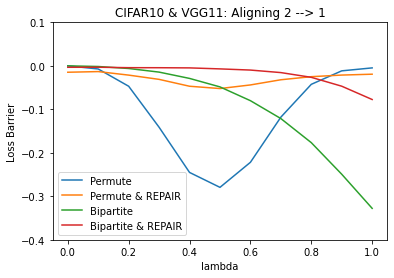

In [38]:
ax = plt.gca()
# plt.axhline(best_acc, label='Best Baseline Acc', color='grey')
plt.plot(alphas, np.array(permute_accuracies) - best_acc, label='Permute')
plt.plot(alphas, np.array(permute_repairs) - best_acc, label='Permute & REPAIR')
plt.plot(alphas, np.array(bipartite_accuracies) - best_acc, label='Bipartite')
plt.plot(alphas, np.array(bipartite_repairs) - best_acc, label='Bipartite & REPAIR')
plt.legend()
ax.set_ylim(-.4, 0.1)
plt.title(f'CIFAR10 & VGG11: Aligning {m1} --> {m0}')
plt.xlabel('lambda')
plt.ylabel('Loss Barrier')
plt.savefig(os.path.join(os.getcwd(), f'cifar10_vgg11_{m1}to{m0}'))
plt.show()

In [39]:
best_acc

0.897

In [165]:
max(bipartite_accuracies)

0.8982